# Chronic Heart Diseases Classification

In [1]:
import random
import pandas as pd
import numpy as np

np.random.seed(42)

import tensorflow

tensorflow.random.set_seed(42)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, matthews_corrcoef, accuracy_score, confusion_matrix, plot_roc_curve
from sklearn.neighbors import KNeighborsClassifier
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.constraints import maxnorm
from warnings import filterwarnings

filterwarnings('ignore')

In [2]:
def custom_scorer(y_true, y_pred, actual_scorer):
    score = np.nan
    try: score = actual_scorer(y_true, y_pred)
    except Exception: pass
    return score

mcc = make_scorer(custom_scorer, actual_scorer = matthews_corrcoef)

# def f1_score(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     recall = true_positives / (possible_positives + K.epsilon())
#     f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
#     return f1_val

def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    return numerator / (denominator + K.epsilon())

### Preprocessing

In [3]:
heart_df = pd.read_csv('../data/Framingham.csv', engine = 'python')
heart_df = heart_df.dropna(axis = 0)

heart_df['male'] = heart_df['male'].astype('category')
heart_df['education'] = heart_df['education'].astype('category')
heart_df['current_smoker'] = heart_df['current_smoker'].astype(int).astype('category')
heart_df['bp_meds'] = heart_df['bp_meds'].astype(int).astype('category')
heart_df['prevalent_stroke'] = heart_df['prevalent_stroke'].astype(int).astype('category')
heart_df['prevalent_hyper'] = heart_df['prevalent_hyper'].astype(int).astype('category')
heart_df['diabetes'] = heart_df['diabetes'].astype(int).astype('category')
heart_df['ten_year_chd'] = heart_df['ten_year_chd'].astype(int).astype('category')

heart_df.head()

,male,age,education,current_smoker,cigs_per_day,bp_meds,prevalent_stroke,prevalent_hyper,diabetes,total_chol,sys_bp,dia_bp,bmi,heart_rate,glucose,ten_year_chd
0,1,39,College,0,0.0,0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,High School or GED,0,0.0,0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,Some High School,1,20.0,0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,Some College or Vocational School,1,30.0,0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,Some College or Vocational School,1,23.0,0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [4]:
full_df = heart_df

full_ddf = pd.get_dummies(full_df['education'], drop_first = True, prefix = 'edu:')
full_ddf = pd.concat([full_ddf, full_df[['male', 'current_smoker', 'bp_meds', 'prevalent_stroke', 
                                         'prevalent_hyper', 'diabetes']]], axis = 1)

full_df = full_df.drop(['education', 'male', 'current_smoker', 'bp_meds', 'prevalent_stroke', 
                        'prevalent_hyper', 'diabetes'], axis = 1)

c = pd.DataFrame(full_df['ten_year_chd']).reset_index(drop = True)

full_df = full_df.drop('ten_year_chd', axis = 1)

def featureNormalize(X):
    return (X - np.mean(X, axis = 0)) / np.std(X, axis = 0, ddof = 1)

X = pd.concat([featureNormalize(full_df), full_ddf], axis = 1).reset_index(drop = True)

In [5]:
X_train = X.sample(random_state = 42, frac = 0.7).sort_index()
c_train = c[X.index.isin(X_train.index)]
X_test = X[~X.index.isin(X_train.index)]
c_test = c[~X.index.isin(X_train.index)]

### k-NN Classification

In [6]:
knnc_k_arr = list(range(1, 21))

knnc = GridSearchCV(KNeighborsClassifier(), 
                    param_grid = {'n_neighbors' : knnc_k_arr}, 
                    cv = 5, scoring = mcc, return_train_score = True)

knnc.fit(X_train.values, c_train.values.ravel())

knnc_df = pd.DataFrame(knnc.cv_results_)

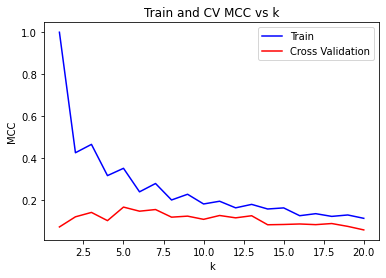

In [7]:
plt.plot(knnc_df['param_n_neighbors'], knnc_df['mean_train_score'], c = 'b', label = 'Train')
plt.plot(knnc_df['param_n_neighbors'], knnc_df['mean_test_score'], c = 'r', label = 'Cross Validation')
plt.legend(loc = 1)
plt.xlabel('k')
plt.ylabel('MCC')
plt.title('Train and CV MCC vs k')
plt.show()

Best Parameters: {'n_neighbors': 5}
Best Cross-Validation MCC: 0.17


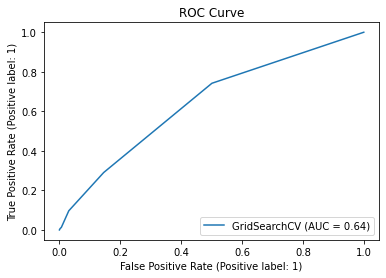

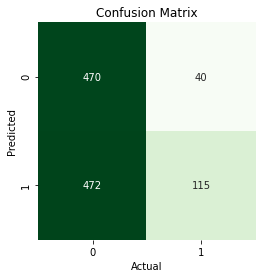

Accuracy: 0.53
Sensitivity: 0.74
Specificity: 0.50


In [8]:
print('Best Parameters: {}'.format(knnc.best_params_))
print('Best Cross-Validation MCC: {:.2f}'.format(knnc.best_score_))

pred_knnc = (knnc.predict_proba(X_test)[:,1] >= 0.12).astype(bool)

plot_roc_curve(knnc, X_test, c_test)
plt.title('ROC Curve')
plt.show()

cm_knnc = confusion_matrix(c_test, pred_knnc)
tn, fp, fn, tp = cm_knnc.ravel()

ax = sns.heatmap(cm_knnc.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_knnc)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

### ANN Classification

#### Model 1: Hyperparameters: Batch size and # of Epochs

In [9]:
def create_model1():
    model = Sequential()
    model.add(Input(shape=(17, )))
    model.add(Dense(5, activation = 'sigmoid'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = [matthews_correlation])
    return model

In [10]:
nnc1_model = KerasClassifier(build_fn = create_model1, verbose = 0)

nnc1_batch_size_arr = [10, 20, 50]
nnc1_epoch_arr = [10, 50, 100]

nnc1 = GridSearchCV(estimator = nnc1_model, 
                    param_grid = {'batch_size' : nnc1_batch_size_arr, 
                                  'epochs' : nnc1_epoch_arr}, 
                    n_jobs = -1, scoring = mcc, cv = 5, return_train_score = True)

nnc1.fit(X_train.values.astype('float64'), c_train.values.ravel(), class_weight = {0: 15.34, 1: 84.77})

nnc1_df = pd.DataFrame(nnc1.cv_results_)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Best Parameters: {'batch_size': 50, 'epochs': 10}
Best Cross-Validation MCC: 0.25


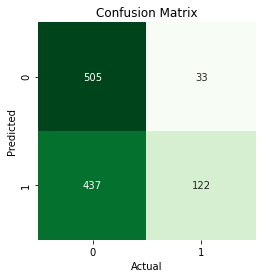

Accuracy: 0.57
Sensitivity: 0.79
Specificity: 0.54


In [11]:
print('Best Parameters: {}'.format(nnc1.best_params_))
print('Best Cross-Validation MCC: {:.2f}'.format(nnc1.best_score_))

pred_nnc1 = nnc1.predict(X_test.values.astype('float64'))

# plot_roc_curve(nnc1, X_test, c_test)
# plt.title('ROC Curve')
# plt.show()

cm_nnc1 = confusion_matrix(c_test, pred_nnc1)
tn, fp, fn, tp = cm_nnc1.ravel()

ax = sns.heatmap(cm_nnc1.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_nnc1)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

#### Model 2: Activation Function of the 1st hidden layer nodes

In [12]:
def create_model2(activation = 'sigmoid'):
    model = Sequential()
    model.add(Input(shape=(17, )))
    model.add(Dense(5, activation = activation))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = [matthews_correlation])
    return model

In [13]:
nnc2_model = KerasClassifier(build_fn = create_model2, batch_size = 50, epochs = 10, verbose = 0)

nnc2_activation_arr = ['linear', 'relu', 'sigmoid', 'tanh']

nnc2 = GridSearchCV(estimator = nnc2_model, 
                    param_grid = {'activation' : nnc2_activation_arr}, 
                    n_jobs = -1, scoring = mcc, cv = 5, return_train_score = True)

nnc2.fit(X_train.values.astype('float64'), c_train.values.ravel(), class_weight = {0: 15.34, 1: 84.77})

nnc2_df = pd.DataFrame(nnc2.cv_results_)

In [14]:
nnc2_df[['param_activation', 'mean_train_score', 'mean_test_score']]

,param_activation,mean_train_score,mean_test_score
0,linear,0.264263,0.246472
1,relu,0.277367,0.227852
2,sigmoid,0.260693,0.235796
3,tanh,0.276019,0.233720


Best Parameters: {'activation': 'linear'}
Best Cross-Validation MCC: 0.25


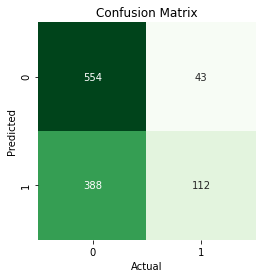

Accuracy: 0.61
Sensitivity: 0.72
Specificity: 0.59


In [15]:
print('Best Parameters: {}'.format(nnc2.best_params_))
print('Best Cross-Validation MCC: {:.2f}'.format(nnc2.best_score_))

pred_nnc2 = nnc2.predict(X_test.values.astype('float64'))

# plot_roc_curve(nnc2, X_test, c_test)
# plt.title('ROC Curve')
# plt.show()

cm_nnc2 = confusion_matrix(c_test, pred_nnc2)
tn, fp, fn, tp = cm_nnc2.ravel()

ax = sns.heatmap(cm_nnc2.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_nnc2)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

#### Model 3: Learning Rate and Momentum of the 1st hidden layer nodes

In [16]:
def create_model3(learn_rate = 0.01, momentum = 0.0):
    model = Sequential()
    model.add(Input(shape=(17, )))
    model.add(Dense(5, activation = 'linear'))
    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = SGD(lr = learn_rate, momentum = momentum)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = [matthews_correlation])
    return model

In [17]:
nnc3_model = KerasClassifier(build_fn = create_model3, batch_size = 50, epochs = 10, verbose = 0)

nnc3_learn_rate_arr = [0.001, 0.01, 0.1, 0.2, 0.5]
nnc3_momentum_arr = [0.0, 0.1, 0.2, 0.5, 0.9]

nnc3 = GridSearchCV(estimator = nnc3_model, 
                    param_grid = {'learn_rate' : nnc3_learn_rate_arr,
                                  'momentum' : nnc3_momentum_arr}, 
                    n_jobs = -1, scoring = mcc, cv = 5, return_train_score = True)

nnc3.fit(X_train.values.astype('float64'), c_train.values.ravel(), class_weight = {0: 15.34, 1: 84.77})

nnc3_df = pd.DataFrame(nnc3.cv_results_)

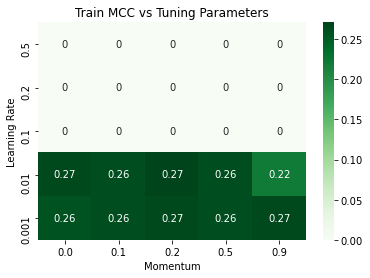

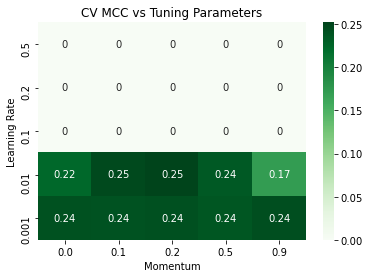

In [18]:
nnc3_train_err_mat = nnc3_df['mean_train_score'].values.reshape(len(nnc3_learn_rate_arr), len(nnc3_momentum_arr))
ax = sns.heatmap(pd.DataFrame(nnc3_train_err_mat, columns = nnc3_momentum_arr, index = nnc3_learn_rate_arr).iloc[::-1], 
                 annot = True, cmap = 'Greens')
ax.set(xlabel = 'Momentum', ylabel = 'Learning Rate', title = 'Train MCC vs Tuning Parameters')
plt.show()

nnc3_cv_err_mat = nnc3_df['mean_test_score'].values.reshape(len(nnc3_learn_rate_arr), len(nnc3_momentum_arr))
ax = sns.heatmap(pd.DataFrame(nnc3_cv_err_mat, columns = nnc3_momentum_arr, index = nnc3_learn_rate_arr).iloc[::-1], 
                 annot = True, cmap = 'Greens')
ax.set(xlabel = 'Momentum', ylabel = 'Learning Rate', title = 'CV MCC vs Tuning Parameters')
plt.show()

Best Parameters: {'learn_rate': 0.01, 'momentum': 0.2}
Best Cross-Validation MCC: 0.25


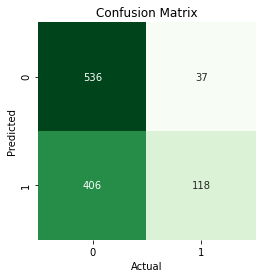

Accuracy: 0.60
Sensitivity: 0.76
Specificity: 0.57


In [19]:
print('Best Parameters: {}'.format(nnc3.best_params_))
print('Best Cross-Validation MCC: {:.2f}'.format(nnc3.best_score_))

pred_nnc3 = nnc3.predict(X_test.values.astype('float64'))

# plot_roc_curve(nnc3, X_test, c_test)
# plt.title('ROC Curve')
# plt.show()

cm_nnc3 = confusion_matrix(c_test, pred_nnc3)
tn, fp, fn, tp = cm_nnc3.ravel()

ax = sns.heatmap(cm_nnc3.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_nnc3)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

#### Model 4: Drop-out Rate and Weight Constraint of the 1st hidden layer nodes

In [20]:
def create_model4(dropout_rate = 0.0, weight_constraint = 0):
    model = Sequential()
    model.add(Input(shape=(17, )))
    model.add(Dense(5, activation = 'linear', kernel_constraint = maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = SGD(lr = 0.01, momentum = 0.2)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = [matthews_correlation])
    return model

In [21]:
nnc4_model = KerasClassifier(build_fn = create_model4, batch_size = 50, epochs = 10, verbose = 0)

nnc4_wgt_constraint_arr = [0, 1, 2, 3, 4, 5]
nnc4_dropout_rate_arr = [0.0, 0.1, 0.2, 0.5, 0.9]

nnc4 = GridSearchCV(estimator = nnc4_model, 
                    param_grid = {'weight_constraint' : nnc4_wgt_constraint_arr,
                                  'dropout_rate' : nnc4_dropout_rate_arr}, 
                    n_jobs = -1, scoring = mcc, cv = 5, return_train_score = True)

nnc4.fit(X_train.values.astype('float64'), c_train.values.ravel(), class_weight = {0: 15.34, 1: 84.77})

nnc4_df = pd.DataFrame(nnc4.cv_results_)

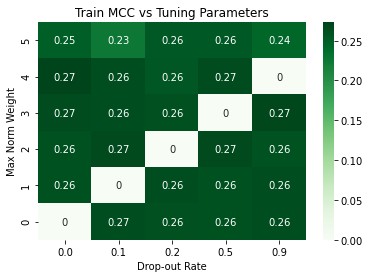

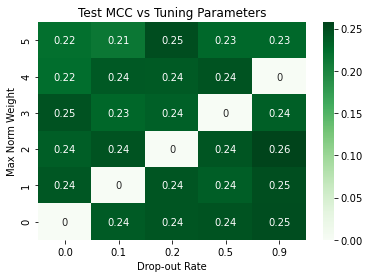

In [22]:
nnc4_train_err_mat = nnc4_df['mean_train_score'].values.reshape(len(nnc4_wgt_constraint_arr), len(nnc4_dropout_rate_arr))
ax = sns.heatmap(pd.DataFrame(nnc4_train_err_mat, columns = nnc4_dropout_rate_arr, 
                              index = nnc4_wgt_constraint_arr).iloc[::-1], annot = True, cmap = 'Greens')
ax.set(xlabel = 'Drop-out Rate', ylabel = 'Max Norm Weight', title = 'Train MCC vs Tuning Parameters')
plt.show()

nnc4_cv_err_mat = nnc4_df['mean_test_score'].values.reshape(len(nnc4_wgt_constraint_arr), len(nnc4_dropout_rate_arr))
ax = sns.heatmap(pd.DataFrame(nnc4_cv_err_mat, columns = nnc4_dropout_rate_arr, 
                              index = nnc4_wgt_constraint_arr).iloc[::-1], annot = True, cmap = 'Greens')
ax.set(xlabel = 'Drop-out Rate', ylabel = 'Max Norm Weight', title = 'Test MCC vs Tuning Parameters')
plt.show()

Best Parameters: {'dropout_rate': 0.2, 'weight_constraint': 2}
Best Cross-Validation Accuracy: 0.26


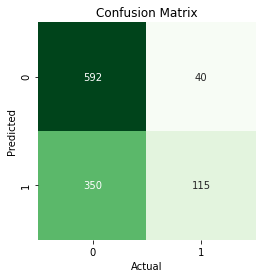

Accuracy: 0.64
Sensitivity: 0.74
Specificity: 0.63


In [23]:
print('Best Parameters: {}'.format(nnc4.best_params_))
print('Best Cross-Validation Accuracy: {:.2f}'.format(nnc4.best_score_))

pred_nnc4 = nnc4.predict(X_test.values.astype('float64'))

# plot_roc_curve(nnc4, X_test, c_test)
# plt.title('ROC Curve')
# plt.show()

cm_nnc4 = confusion_matrix(c_test, pred_nnc4)
tn, fp, fn, tp = cm_nnc4.ravel()

ax = sns.heatmap(cm_nnc4.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_nnc4)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

#### Model 5: # of Neurons in the 1st hidden layer

In [24]:
def create_model5(neurons = 0):
    model = Sequential()
    model.add(Input(shape=(17, )))
    model.add(Dense(neurons, activation = 'linear', kernel_constraint = maxnorm(2)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = SGD(lr = 0.01, momentum = 0.2)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = [matthews_correlation])
    return model

In [25]:
nnc5_model = KerasClassifier(build_fn = create_model5, batch_size = 50, epochs = 10, verbose = 0)

nnc5_neuron_arr = [1, 5, 10, 15, 20, 25, 30]

nnc5 = GridSearchCV(estimator = nnc5_model, 
                    param_grid = {'neurons' : nnc5_neuron_arr}, 
                    n_jobs = -1, scoring = mcc, cv = 5, return_train_score = True)

nnc5.fit(X_train.values.astype('float64'), c_train.values.ravel(), class_weight = {0: 15.34, 1: 84.77})

nnc5_df = pd.DataFrame(nnc5.cv_results_)

In [26]:
nnc5_df[['param_neurons', 'mean_train_score', 'mean_test_score']]

,param_neurons,mean_train_score,mean_test_score
0,1,0.260579,0.237628
1,5,0.264919,0.234425
2,10,0.268057,0.230486
3,15,0.263449,0.240203
4,20,0.268890,0.250125
5,25,0.260944,0.238977
6,30,0.270872,0.228097


Best Parameters: {'neurons': 20}
Best Cross-Validation Accuracy: 0.25


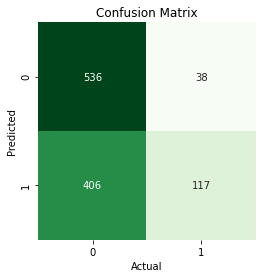

Accuracy: 0.60
Sensitivity: 0.75
Specificity: 0.57


In [27]:
print('Best Parameters: {}'.format(nnc5.best_params_))
print('Best Cross-Validation Accuracy: {:.2f}'.format(nnc5.best_score_))

pred_nnc5 = nnc5.predict(X_test.values.astype('float64'))

# plot_roc_curve(nnc5, X_test, c_test)
# plt.title('ROC Curve')
# plt.show()

cm_nnc5 = confusion_matrix(c_test, pred_nnc5)
tn, fp, fn, tp = cm_nnc5.ravel()

ax = sns.heatmap(cm_nnc5.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_nnc5)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

#### Model 6: # of Neurons in the 2nd hidden layer

In [28]:
def create_model6(neurons = 0):
    model = Sequential()
    model.add(Input(shape=(17, )))
    model.add(Dense(20, activation = 'linear', kernel_constraint = maxnorm(2)))
    model.add(Dropout(0.2))
    model.add(Dense(neurons, activation = 'linear', kernel_constraint = maxnorm(2)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = SGD(lr = 0.01, momentum = 0.2)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = [matthews_correlation])
    return model

In [29]:
nnc6_model = KerasClassifier(build_fn = create_model6, batch_size = 50, epochs = 10, verbose = 0)

nnc6_neuron_arr = [1, 5, 10, 15, 20, 25, 30]

nnc6 = GridSearchCV(estimator = nnc6_model, 
                    param_grid = {'neurons' : nnc6_neuron_arr}, 
                    n_jobs = -1, scoring = mcc, cv = 5, return_train_score = True)

nnc6.fit(X_train.values.astype('float64'), c_train.values.ravel(), class_weight = {0: 15.34, 1: 84.77})

nnc6_df = pd.DataFrame(nnc6.cv_results_)

In [30]:
nnc6_df[['param_neurons', 'mean_train_score', 'mean_test_score']]

,param_neurons,mean_train_score,mean_test_score
0,1,0.257163,0.241513
1,5,0.257065,0.248608
2,10,0.263906,0.246685
3,15,0.262105,0.256295
4,20,0.258843,0.252780
5,25,0.264989,0.239757
6,30,0.257528,0.243439


Best Parameters: {'neurons': 15}
Best Cross-Validation Accuracy: 0.26


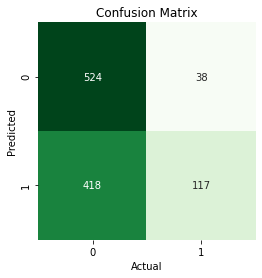

Accuracy: 0.58
Sensitivity: 0.75
Specificity: 0.56


In [31]:
print('Best Parameters: {}'.format(nnc6.best_params_))
print('Best Cross-Validation Accuracy: {:.2f}'.format(nnc6.best_score_))

pred_nnc6 = nnc6.predict(X_test.values.astype('float64'))

# plot_roc_curve(nnc6, X_test, c_test)
# plt.title('ROC Curve')
# plt.show()

cm_nnc6 = confusion_matrix(c_test, pred_nnc6)
tn, fp, fn, tp = cm_nnc6.ravel()

ax = sns.heatmap(cm_nnc6.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_nnc6)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

In [32]:
# def final_model():
#     model = Sequential()
#     model.add(Input(shape=(17, )))
#     model.add(Dense(neurons = 20, activation = 'linear', kernel_constraint = maxnorm(2)))
#     model.add(Dropout(0.2))
#     model.add(Dense(1, activation = 'sigmoid'))
#     optimizer = SGD(lr = 0.01, momentum = 0.2)
#     model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = [matthews_correlation])
#     return model
# annc_model = KerasClassifier(build_fn = final_model, batch_size = 50, epochs = 10, verbose = 0)
# annc_model.fit(X_train.values.astype('float64'), c_train.values.ravel(), class_weight = {0: 15.34, 1: 84.77})